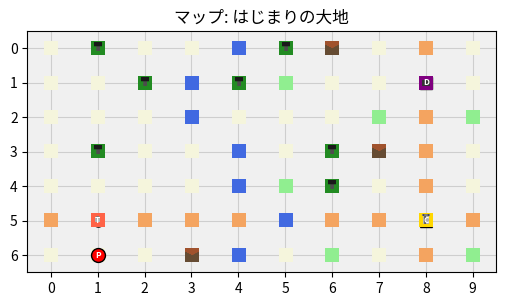


=== ターン 2 ===
現在位置: (6, 1) - 平地
勇者 HP: 100/100 MP: 50/50
移動ポイント: 99.0

移動方向を選択してください（w: 上, a: 左, s: 下, d: 右, r: 休息, i: インベントリ, q: 終了）


コマンド >  s


下には移動できません。


In [ ]:
# main.ipynb

# RPGシミュレーター - メイン
# 
# このノートブックは、RPGシミュレーターのメインエントリーポイントです。
# 他のノートブックを読み込み、シミュレーションを実行します。

# main.ipynb 先頭部分に追加するコード

# モジュール化に向けた設定
import os
import sys
import json
import random
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

# マップシステムを最初に読み込む（元々後ろの方にあった）
%run notebooks/map_system.ipynb

# マップシステムの初期化
print("\n===== マップシステムの初期化 =====")

# マップシステムを初期化
game_map = create_sample_map()
print(f"マップ '{game_map.name}' を初期化しました（サイズ: {game_map.width}x{game_map.height}）")

# 既存のモジュールを読み込む
%run notebooks/characters.ipynb
%run notebooks/battle_system.ipynb
%run notebooks/skills.ipynb  # 既存のコードを保持

# データディレクトリがなければ作成
data_dir = 'data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print(f"'{data_dir}'ディレクトリを作成しました。")
else:
    print(f"'{data_dir}'ディレクトリは既に存在します。")

# ## サンプルデータファイルの作成

def create_sample_data_files():
    """サンプルのデータファイルを作成する"""
    
    # キャラクターデータ
    characters_data = [
        {
            "name": "勇者",
            "hp": 100,
            "mp": 50,
            "strength": 15,
            "defense": 10,
            "magic": 8,
            "speed": 12,
            "level": 1,
            "job": "戦士",
            "exp": 0,
            "next_level_exp": 100
        },
        {
            "name": "魔法使い",
            "hp": 70,
            "mp": 100,
            "strength": 6,
            "defense": 6,
            "magic": 18,
            "speed": 10,
            "level": 1,
            "job": "魔法使い",
            "exp": 0,
            "next_level_exp": 100
        },
        {
            "name": "盗賊",
            "hp": 80,
            "mp": 40,
            "strength": 12,
            "defense": 8,
            "magic": 7,
            "speed": 15,
            "level": 1,
            "job": "盗賊",
            "exp": 0,
            "next_level_exp": 100
        }
    ]
    
    # 敵データ
    enemies_data = [
        {
            "name": "スライム",
            "hp": 50,
            "mp": 0,
            "strength": 8,
            "defense": 5,
            "magic": 0,
            "speed": 6,
            "level": 1,
            "exp_reward": 15,
            "enemy_type": "スライム"
        },
        {
            "name": "ゴブリン",
            "hp": 80,
            "mp": 10,
            "strength": 12,
            "defense": 8,
            "magic": 4,
            "speed": 10,
            "level": 2,
            "exp_reward": 25,
            "enemy_type": "通常"
        },
        {
            "name": "オオカミ",
            "hp": 65,
            "mp": 0,
            "strength": 14,
            "defense": 6,
            "magic": 0,
            "speed": 14,
            "level": 2,
            "exp_reward": 30,
            "enemy_type": "獣"
        },
        {
            "name": "ゴーレム",
            "hp": 150,
            "mp": 0,
            "strength": 18,
            "defense": 15,
            "magic": 0,
            "speed": 5,
            "level": 5,
            "exp_reward": 100,
            "enemy_type": "ボス"
        }
    ]
    
    # JSONファイルとして保存
    characters_file = os.path.join(data_dir, 'characters.json')
    enemies_file = os.path.join(data_dir, 'enemies.json')
    
    with open(characters_file, 'w', encoding='utf-8') as f:
        json.dump(characters_data, f, ensure_ascii=False, indent=4)
    
    with open(enemies_file, 'w', encoding='utf-8') as f:
        json.dump(enemies_data, f, ensure_ascii=False, indent=4)
    
    print(f"サンプルデータファイルを作成しました:")
    print(f"- {characters_file}")
    print(f"- {enemies_file}")

# サンプルデータファイルの作成
create_sample_data_files()

# ## データの読み込みと準備

# キャラクターと敵のデータを読み込む
characters = load_characters_from_json(os.path.join(data_dir, 'characters.json'))
enemies = load_enemies_from_json(os.path.join(data_dir, 'enemies.json'))

print("プレイヤーキャラクター:")
for character in characters:
    print(f"- {character.name} (Lv.{character.level} {character.job})")

print("\n敵キャラクター:")
for enemy in enemies:
    print(f"- {enemy.name} (Lv.{enemy.level} {enemy.enemy_type})")

# キャラクターにサンプルスキルを設定
print("\n===== スキルの設定 =====")
skills = create_sample_skills()

for character in characters:
    if character.job == "戦士":
        character.learn_skill("斬りつけ")
        character.learn_skill("全体斬り")
    elif character.job == "魔法使い":
        character.learn_skill("斬りつけ")  # 基本スキルとして持たせる
    elif character.job == "盗賊":
        character.learn_skill("斬りつけ")
        
# キャラクターのスキル一覧を表示
print("\nキャラクターのスキル:")
for character in characters:
    print(f"{character.name} ({character.job}) のスキル:")
    for skill_name in character.skills:
        if skill_name in skills:
            skill = skills[skill_name]
            print(f"  - {skill_name}: {skill.description} (MP: {skill.mp_cost})")

# ## バトルシミュレーション

def run_single_battle():
    """1対1の戦闘をシミュレート - ランダムな敵を使用"""
    
    print("\n===== 1対1の戦闘 =====")
    player = characters[0]  # 勇者（変更なし）
    enemy = random.choice(enemies)  # ランダムな敵を選択
    
    print(f"戦闘: {player.name} vs {enemy.name} (Lv.{enemy.level} {enemy.enemy_type})")
    
    # 新しいインスタンスを作成してバトルに使用
    player_copy = PlayerCharacter(
        name=player.name,
        hp=player.max_hp,
        mp=player.max_mp,
        strength=player.strength,
        defense=player.defense,
        magic=player.magic,
        speed=player.speed,
        level=player.level,
        job=player.job
    )
    
    enemy_copy = Enemy(
        name=enemy.name,
        hp=enemy.max_hp,
        mp=enemy.max_mp,
        strength=enemy.strength,
        defense=enemy.defense,
        magic=enemy.magic,
        speed=enemy.speed,
        level=enemy.level,
        exp_reward=enemy.exp_reward,
        enemy_type=enemy.enemy_type
    )
    
    result, battle_log = simulate_battle([player_copy], [enemy_copy])
    
    print(f"\n戦闘結果: {result}")
    
    return result, battle_log
    
def run_team_battle():
    """チーム戦をシミュレート - ランダムな敵チーム"""
    
    print("\n===== チーム戦 =====")
    player_team = characters[:2]  # 勇者と魔法使い（変更なし）
    
    # 敵チームをランダムに選択（2体）
    enemy_team_size = 2
    enemy_team = random.sample(enemies, enemy_team_size)
    
    player_names = [p.name for p in player_team]
    enemy_names = [e.name for e in enemy_team]
    
    print(f"戦闘: {' & '.join(player_names)} vs {' & '.join(enemy_names)}")
    
    # 各キャラクターの新しいインスタンスを作成
    player_team_copy = []
    for player in player_team:
        new_player = PlayerCharacter(
            name=player.name,
            hp=player.max_hp,
            mp=player.max_mp,
            strength=player.strength,
            defense=player.defense,
            magic=player.magic,
            speed=player.speed,
            level=player.level,
            job=player.job
        )
        player_team_copy.append(new_player)
        
    enemy_team_copy = []
    for enemy in enemy_team:
        new_enemy = Enemy(
            name=enemy.name,
            hp=enemy.max_hp,
            mp=enemy.max_mp,
            strength=enemy.strength,
            defense=enemy.defense,
            magic=enemy.magic,
            speed=enemy.speed,
            level=enemy.level,
            exp_reward=enemy.exp_reward,
            enemy_type=enemy.enemy_type
        )
        enemy_team_copy.append(new_enemy)
    
    result, battle_log = simulate_battle(player_team_copy, enemy_team_copy)
    
    print(f"\n戦闘結果: {result}")
    
    return result, battle_log

def run_boss_battle():
    """ボス戦をシミュレート"""
    
    print("\n===== ボス戦 =====")
    player_team = characters  # 全プレイヤー
    boss = [enemies[3]]       # ゴーレム
    
    player_names = [p.name for p in player_team]
    
    print(f"戦闘: {' & '.join(player_names)} vs {boss[0].name}")
    result, battle_log = simulate_battle(player_team, boss)
    
    print(f"\n戦闘結果: {result}")
    
    return result, battle_log

def run_balance_test(num_simulations=100):
    """バランステスト（複数回のシミュレーション） - ランダムな敵で"""
    
    print(f"\n===== バランステスト ({num_simulations}回) =====")
    player = characters[0]  # 勇者（変更なし）
    
    # 異なる敵に対するパフォーマンスをテストするため、ランダムな敵を選択
    enemy = random.choice(enemies)
    
    print(f"テスト: {player.name} vs {enemy.name} x {num_simulations}回")
    
    # 詳細ログなしで複数回シミュレーション
    stats = simulate_multiple_battles([player], [enemy], num_simulations, show_detailed_log=False)
    
    print(f"\n結果:")
    print(f"勝率: {stats['victory_rate']:.1f}%")
    print(f"平均ターン数: {stats['average_turns']:.1f}")
    print(f"平均戦闘時間: {stats['average_time']:.3f}秒")
    
    return stats
# 2025.3.19視覚モードでシングルバトルをテスト
def run_visual_battle():
    """視覚的表示付きの1対1の戦闘をシミュレート - ランダムな敵"""
    
    print("\n===== 視覚モードの戦闘 =====")
    player = characters[0]  # 勇者（変更なし）
    enemy = random.choice(enemies)  # ランダムな敵を選択
    
    print(f"戦闘: {player.name} vs {enemy.name} (Lv.{enemy.level} {enemy.enemy_type})")
    
    # 新しいインスタンスを作成
    player_copy = PlayerCharacter(
        name=player.name,
        hp=player.max_hp,
        mp=player.max_mp,
        strength=player.strength,
        defense=player.defense,
        magic=player.magic,
        speed=player.speed,
        level=player.level,
        job=player.job
    )
    
    enemy_copy = Enemy(
        name=enemy.name,
        hp=enemy.max_hp,
        mp=enemy.max_mp,
        strength=enemy.strength,
        defense=enemy.defense,
        magic=enemy.magic,
        speed=enemy.speed,
        level=enemy.level,
        exp_reward=enemy.exp_reward,
        enemy_type=enemy.enemy_type
    )
    
    # visual_modeをTrueに設定
    result, battle_log = simulate_battle([player_copy], [enemy_copy], show_detailed_log=False, visual_mode=True)
    
    print(f"\n戦闘結果: {result}")
    
    return result, battle_log

# ## 戦闘分析と可視化

def visualize_battle_stats(stats):
    """戦闘統計を可視化"""
    
    # 日本語フォント設定の修正
    try:
        # まずmatplotlibで利用可能なフォントを確認
        import matplotlib.font_manager as fm
        fonts = [f.name for f in fm.fontManager.ttflist]
        
        # 一般的な日本語フォントのリスト
        japanese_fonts = ['IPAGothic', 'MS Gothic', 'Hiragino Sans', 'Meiryo', 'TakaoGothic', 
                          'Noto Sans CJK JP', 'Yu Gothic', 'sans-serif']
        
        # システムにある日本語フォントを探して設定
        for font in japanese_fonts:
            if font in fonts:
                plt.rcParams['font.family'] = font
                print(f"フォント '{font}' を使用します")
                break
        else:
            # 日本語フォントが見つからない場合はデフォルトフォントを使用
            print("日本語フォントが見つかりませんでした。デフォルトフォントを使用します")
            plt.rcParams['font.family'] = 'sans-serif'
            # ラベルを英語に変更
            labels = ['Victory', 'Defeat', 'Draw']
    except Exception as e:
        print(f"フォント設定エラー: {e}")
        plt.rcParams['font.family'] = 'sans-serif'
        # ラベルを英語に変更
        labels = ['Victory', 'Defeat', 'Draw']
    
    plt.figure(figsize=(12, 6))
    
    # 勝敗グラフ
    plt.subplot(1, 2, 1)
    if 'labels' not in locals():
        labels = ['勝利', '敗北', '引き分け']
    sizes = [stats['victory'], stats['defeat'], stats['draw']]
    colors = ['#66c2a5', '#fc8d62', '#8da0cb']
    
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Battle Results Distribution' if 'Victory' in labels else '戦闘結果の分布')
    
    # ターン数分布
    plt.subplot(1, 2, 2)
    turn_counts = [len([log for log in logs if "ターン" in str(log) and "====" in str(log)]) for logs in stats['logs']]
    plt.hist(turn_counts, bins=range(min(turn_counts) if turn_counts else 0, 
                                    max(turn_counts) + 2 if turn_counts else 10), 
             alpha=0.7, color='#8da0cb')
    plt.xlabel('Turns' if 'Victory' in labels else 'ターン数')
    plt.ylabel('Frequency' if 'Victory' in labels else '頻度')
    plt.title('Battle Turn Distribution' if 'Victory' in labels else '戦闘ターン数の分布')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# アイテムシステムの初期化のみ行う
print("\n===== アイテムシステムの初期化 =====")
%run ./notebooks/items.ipynb
items = create_sample_items()

# プレイヤーに初期アイテムを追加
player = characters[0]  # 勇者
player.add_item("potion", 3)
player.add_item("bronze_sword", 1)
print("アイテムシステムを初期化しました")

# キャラクターを取得（勇者を使用）
hero = characters[0]

# 始まりの村の位置を取得
town_pos = [(row, col) for (row, col), loc in game_map.locations.items() 
           if loc.name == "始まりの村"]
if town_pos:
    player_row, player_col = town_pos[0]
else:
    player_row, player_col = 7, 3  # デフォルト位置

# プレイヤーをマップに配置
map_player = MapPlayer(hero, player_row, player_col)

# マップを表示
game_map.display((map_player.row, map_player.col))

# 現在地の情報を表示
print(f"\n現在位置: ({map_player.row}, {map_player.col})")
curr_tile = game_map.get_tile(map_player.row, map_player.col)
print(f"現在のタイル: {TILE_NAMES[curr_tile]}")
location = game_map.get_location(map_player.row, map_player.col)
if location:
    print(f"現在地: {location.name} - {location.description}")
    for event in location.events:
        print(f"イベント: {event['name']} - {event['description']}")

# インタラクティブ移動を実行するかどうかの質問
print("\nマップの準備ができました。RPGモード起動時にマップを探索できます。")

# マップを保存
save_path = os.path.join('data', 'world_map.json')
game_map.save_to_file(save_path)
print(f"マップを保存しました: {save_path}")

print("\n===== マップシステムの初期化完了 =====")



# インタラクティブなRPGモードを実装
def run_rpg_mode():
    """インタラクティブなRPGモード - マップ移動とバトルを統合"""
    global map_player, game_map, hero, enemies, items, skills
    
    # ゲーム状態の初期化
    hero = characters[0]  # 勇者を使用
    hero.current_hp = hero.max_hp
    hero.current_mp = hero.max_mp
    
    # 始まりの村の位置を取得
    town_pos = [(row, col) for (row, col), loc in game_map.locations.items() 
               if loc.name == "始まりの村"]
    if town_pos:
        player_row, player_col = town_pos[0]
    else:
        player_row, player_col = 7, 3  # デフォルト位置
    
    # プレイヤーをマップに配置
    map_player = MapPlayer(hero, player_row, player_col)
    
    # ゲームの説明
    clear_output(wait=True)
    print("===== RPG シミュレーター =====")
    print("マップを移動して敵と戦い、冒険を楽しみましょう！")
    print(f"あなたのキャラクター: {hero.name} (Lv.{hero.level} {hero.job})")
    print(f"HP: {hero.current_hp}/{hero.max_hp}, MP: {hero.current_mp}/{hero.max_mp}")
    print(f"攻撃力: {hero.strength}, 防御力: {hero.defense}, 素早さ: {hero.speed}")
    print("\nスキル:")
    for skill_name in hero.skills:
        if skill_name in skills:
            skill = skills[skill_name]
            print(f"  - {skill_name}: {skill.description} (MP: {skill.mp_cost})")
    
    # マップとコマンドの説明
    print("\n=== 移動コマンド ===")
    print("w: 上に移動")
    print("d: 右に移動")
    print("s: 下に移動")
    print("a: 左に移動")
    print("r: 休息する（HP/MP回復）")
    print("i: インベントリを確認")
    print("q: ゲームを終了")
    #print("\n準備ができたらEnterキーを押してください...")
    #input()
    
    # メインゲームループ
    game_active = True
    steps = 0
    battles_won = 0
    
    # ゲームメインループ
    while game_active:
        # ====== マップ表示フェーズ ======
        steps += 1
        clear_output(wait=True)
        # 視覚的に改良されたマップ表示を使用
        game_map.display_with_images((map_player.row, map_player.col))
        
        # 現在地の情報表示
        curr_tile = game_map.get_tile(map_player.row, map_player.col)
        location = game_map.get_location(map_player.row, map_player.col)
        
        print(f"\n=== ターン {steps} ===")
        print(f"現在位置: ({map_player.row}, {map_player.col}) - {TILE_NAMES[curr_tile]}")
        print(f"{hero.name} HP: {hero.current_hp}/{hero.max_hp} MP: {hero.current_mp}/{hero.max_mp}")
        print(f"移動ポイント: {map_player.movement_points:.1f}")
        
        # 位置に特別な場所がある場合は表示
        if location:
            print(f"\n>>> {location.name} <<<")
            print(f"{location.description}")
            
            # 初めて訪れた場所の場合、イベントを表示
            if not location.visited:
                location.visited = True
                print("\n[新しい場所を発見しました]")
                for event in location.events:
                    print(f"イベント: {event['name']} - {event['description']}")
                
                # 町では自動回復
                if location.loc_type == "town":
                    old_hp = hero.current_hp
                    old_mp = hero.current_mp
                    hero.current_hp = hero.max_hp
                    hero.current_mp = hero.max_mp
                    print(f"\n町に到着し、休息をとりました。")
                    print(f"HPが {old_hp} → {hero.current_hp} に回復")
                    print(f"MPが {old_mp} → {hero.current_mp} に回復")
        
        # ====== 移動コマンド入力フェーズ ======
        print("\n移動方向を選択してください（w: 上, a: 左, s: 下, d: 右, r: 休息, i: インベントリ, q: 終了）")
        cmd = input("コマンド > ").lower()
        
        # コマンド処理
        if cmd == "q":
            print("\nゲームを終了します。")
            game_active = False
            continue
        elif cmd == "r":
            # 休息（移動ポイントとHP/MPを回復）
            old_mp = map_player.movement_points
            old_hp = hero.current_hp
            old_mp_val = hero.current_mp
            
            map_player.rest()
            
            print(f"\n休息を取りました。")
            print(f"移動ポイントが {old_mp:.1f} → {map_player.movement_points:.1f} に回復")
            print(f"HPが {old_hp} → {hero.current_hp} に回復")
            print(f"MPが {old_mp_val} → {hero.current_mp} に回復")
            input("\nEnterキーを押して続行...")
            continue
        elif cmd == "i":
            # インベントリ表示
            print("\n=== インベントリ ===")
            if hasattr(hero, 'inventory') and hero.inventory:
                for item_id, count in hero.inventory.items():
                    if item_id in items:
                        print(f"- {items[item_id].name} x{count}: {items[item_id].description}")
            else:
                print("インベントリは空です。")
            
            # 装備品表示
            if hasattr(hero, 'equipment'):
                print("\n=== 装備 ===")
                for slot, item_id in hero.equipment.items():
                    if item_id and item_id in items:
                        item = items[item_id]
                        bonuses = ", ".join([f"{stat}+{val}" for stat, val in item.stat_bonuses.items()])
                        print(f"- {slot}: {item.name} ({bonuses})")
                    else:
                        print(f"- {slot}: なし")
            
            input("\nEnterキーを押して続行...")
            continue
        elif cmd in ["w", "a", "s", "d"]:
            # 方向を設定
            if cmd == "w":
                direction = DIRECTION_UP
            elif cmd == "a":
                direction = DIRECTION_LEFT
            elif cmd == "s":
                direction = DIRECTION_DOWN
            elif cmd == "d":
                direction = DIRECTION_RIGHT
            
            # ====== 移動実行フェーズ ======
            success, location, encounter = map_player.move(direction, game_map)
            
            if not success:
                direction_name = ["上", "右", "下", "左"][direction]
                print(f"{direction_name}には移動できません。")
                input("\nEnterキーを押して続行...")
                continue
            
            # 移動成功メッセージ（一時表示）
            direction_name = ["北", "東", "南", "西"][direction]
            print(f"{direction_name}へ移動しました。")
            
            # ====== エンカウントフェーズ ======
            if encounter:
                # 少し間を置いてエンカウント演出
                print(".")
                time.sleep(0.3)
                print("..")
                time.sleep(0.3)
                print("...")
                time.sleep(0.3)
                
                # 敵を選択（現在地に応じて調整）
                curr_tile = game_map.get_tile(map_player.row, map_player.col)
                if curr_tile == TILE_FOREST:
                    # 森では強い敵が出やすい
                    enemy_options = [e for e in enemies if e.level >= hero.level]
                    if not enemy_options:
                        enemy_options = enemies
                elif curr_tile == TILE_MOUNTAIN:
                    # 山では特に強い敵
                    enemy_options = [e for e in enemies if e.level >= hero.level + 1]
                    if not enemy_options:
                        enemy_options = [e for e in enemies if e.level >= hero.level]
                        if not enemy_options:
                            enemy_options = enemies
                else:
                    # 通常の敵
                    enemy_options = enemies
                
                enemy = random.choice(enemy_options)
                
                # ====== 戦闘開始フェーズ ======
                clear_output(wait=True)
                print(f"\n!!! {enemy.name}が現れた !!!")
                
                # バトル確認
                battle_cmd = input("戦闘しますか？ (y/n) > ").lower()
                
                if battle_cmd == "y":
                    # 敵のコピーを作成してバトル
                    enemy_copy = Enemy(
                        name=enemy.name,
                        hp=enemy.max_hp,
                        mp=enemy.max_mp,
                        strength=enemy.strength,
                        defense=enemy.defense,
                        magic=enemy.magic,
                        speed=enemy.speed,
                        level=enemy.level,
                        exp_reward=enemy.exp_reward,
                        enemy_type=enemy.enemy_type
                    )
                    
                    # ====== 戦闘実行フェーズ ======
                    print("\n===== 戦闘開始 =====")
                    # 視覚的なバトルを実行
                    result, battle_log = simulate_battle([hero], [enemy_copy], show_detailed_log=True, visual_mode=True)
                    
                    # ====== 戦闘結果表示フェーズ ======
                    clear_output(wait=True)
                    print("\n===== 戦闘結果 =====")
                    
                    if result == "victory":
                        battles_won += 1
                        print(f"\n{enemy.name}に勝利しました！")
                        
                        # 経験値獲得（直接更新）
                        old_level = hero.level
                        old_exp = hero.exp
                        leveled_up = hero.gain_exp(enemy.exp_reward)
                        
                        print(f"経験値を{enemy.exp_reward}獲得！ ({old_exp} → {hero.exp})")
                        
                        if leveled_up:
                            print(f"\n=== レベルアップ！ ===")
                            print(f"{old_level} → {hero.level}")
                            print(f"HP: {hero.max_hp - 25} → {hero.max_hp}")
                            print(f"MP: {hero.max_mp - 5} → {hero.max_mp}")
                            print(f"攻撃力: {hero.strength - 3} → {hero.strength}")
                            print(f"防御力: {hero.defense - 2} → {hero.defense}")
                            
                            # レベルアップ時の特別な処理
                            if hero.level == 3 and hero.job == "戦士" and "大振り" not in hero.skills:
                                hero.learn_skill("大振り")
                                print("\n新しいスキル「大振り」を習得しました！")
                                
                            if hero.level == 5 and "必殺技" not in hero.skills:
                                hero.learn_skill("必殺技")
                                print("\n新しいスキル「必殺技」を習得しました！")
                        
                        # アイテムドロップ（シンプルな実装）
                        if random.random() < 0.3:  # 30%の確率でアイテムドロップ
                            potion_count = random.randint(1, 3)
                            if hasattr(hero, 'add_item'):
                                hero.add_item("potion", potion_count)
                                print(f"\n{enemy.name}からポーションx{potion_count}を入手しました！")
                    else:
                        print("\n戦闘に敗北してしまいました...")
                        # 敗北時は体力を少し回復
                        hero.current_hp = max(1, hero.max_hp // 5)
                        print(f"何とか逃げ出し、体力をわずかに回復しました。(HP: {hero.current_hp})")
                    
                    print("\n===== マップに戻ります =====")
                    input("Enterキーを押して続行...")
                
                else:
                    # 戦闘回避
                    escape_chance = hero.speed / (hero.speed + enemy.speed)
                    if random.random() < escape_chance:
                        print("敵から逃げ切りました。")
                    else:
                        print("逃げようとしましたが、失敗しました！")
                        # 逃走失敗時は少しダメージを受ける
                        damage = max(1, enemy.strength // 2)
                        hero.take_damage(damage)
                        print(f"{enemy.name}の攻撃で{damage}のダメージを受けました！")
                        print(f"残りHP: {hero.current_hp}/{hero.max_hp}")
                        
                        # HP0になったら町に強制送還
                        if not hero.is_alive:
                            print("\n戦闘不能になりました...")
                            # 始まりの村に戻る
                            town_pos = [(row, col) for (row, col), loc in game_map.locations.items() 
                                       if loc.name == "始まりの村"]
                            if town_pos:
                                map_player.row, map_player.col = town_pos[0]
                            
                            # 体力を少し回復
                            hero.current_hp = max(1, hero.max_hp // 3)
                            hero.is_alive = True
                            print(f"目を覚ますと、{game_map.get_location(map_player.row, map_player.col).name}にいました。")
                            print(f"体力をある程度回復しました。(HP: {hero.current_hp}/{hero.max_hp})")
                    
                    print("\n===== マップに戻ります =====")
                    input("Enterキーを押して続行...")
        else:
            print("無効なコマンドです。w, a, s, d, r, i, q のいずれかを入力してください。")
            input("\nEnterキーを押して続行...")
            continue
    
    # ゲーム終了時の統計
    print("\n===== ゲーム終了 =====")
    print(f"移動回数: {steps}")
    print(f"勝利した戦闘: {battles_won}")
    print(f"最終レベル: {hero.level} ({hero.job})")
    print(f"HP: {hero.current_hp}/{hero.max_hp}")
    print(f"MP: {hero.current_mp}/{hero.max_mp}")
    print(f"攻撃力: {hero.strength}, 防御力: {hero.defense}, 素早さ: {hero.speed}")
    
    # 習得したスキル
    print("\nスキル:")
    for skill_name in hero.skills:
        if skill_name in skills:
            skill = skills[skill_name]
            print(f"  - {skill_name}: {skill.description} (MP: {skill.mp_cost})")
    
    # 持っているアイテム
    if hasattr(hero, 'inventory') and hero.inventory:
        print("\nアイテム:")
        for item_id, count in hero.inventory.items():
            if item_id in items:
                print(f"  - {items[item_id].name} x{count}")    
# ゲーム終了時の統計
    print("\n===== ゲーム終了 =====")
    print(f"移動回数: {steps}")
    print(f"勝利した戦闘: {battles_won}")
    print(f"最終レベル: {hero.level} ({hero.job})")
    print(f"HP: {hero.current_hp}/{hero.max_hp}")
    print(f"MP: {hero.current_mp}/{hero.max_mp}")
    print(f"攻撃力: {hero.strength}, 防御力: {hero.defense}, 素早さ: {hero.speed}")
    
    # 習得したスキル
    print("\nスキル:")
    for skill_name in hero.skills:
        if skill_name in skills:
            skill = skills[skill_name]
            print(f"  - {skill_name}: {skill.description} (MP: {skill.mp_cost})")
    
    # 持っているアイテム
    if hasattr(hero, 'inventory') and hero.inventory:
        print("\nアイテム:")
        for item_id, count in hero.inventory.items():
            if item_id in items:
                print(f"  - {items[item_id].name} x{count}")

# メインプログラムの最後に追加して、RPGモードを実行できるようにする
print("\n=== RPGモードを起動する ===")
run_rpg_mode()